## Visualising electron density
Load a saved model, sample to get locations and get a plot for the electron densities

In [30]:
from nn import model, psi_nn

In [47]:
import torch
import numpy as np

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
checkpoint = torch.load("model_500ep.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [24]:
from cluster_nn import metropolis, get_local_energy, get_variances

mc_steps = 50
n_walkers = 4096
keep_mc_steps = False
device = torch.device("cuda")
cpu = torch.device("cpu")

In [58]:
pos = torch.rand((n_walkers, 6))
for epoch in range(10):

    with torch.no_grad():
        pos = metropolis(
            mc_steps, pos, n_walkers, model.to(cpu), keep_mc_steps=keep_mc_steps)

    E = get_local_energy(
        pos.to(device), model.to(device))
    
    variance = get_variances(E)
    mean_energy = torch.mean(E)

In [121]:
n_walkers = 100000
pos = torch.rand((n_walkers, 6))
pos = metropolis(
            mc_steps, pos, n_walkers, model.to(cpu), keep_mc_steps=keep_mc_steps)


In [122]:
prob_density = (psi_nn(pos, model)).detach().to(cpu)

In [104]:
t = torch.meshgrid(torch.arange(-1, 1, 0.1), torch.arange(-1, 1, 0.1), torch.arange(-1, 1, 0.1), torch.arange(-1, 1, 0.1), torch.arange(-1, 1, 0.1), torch.arange(-1, 1, 0.1))

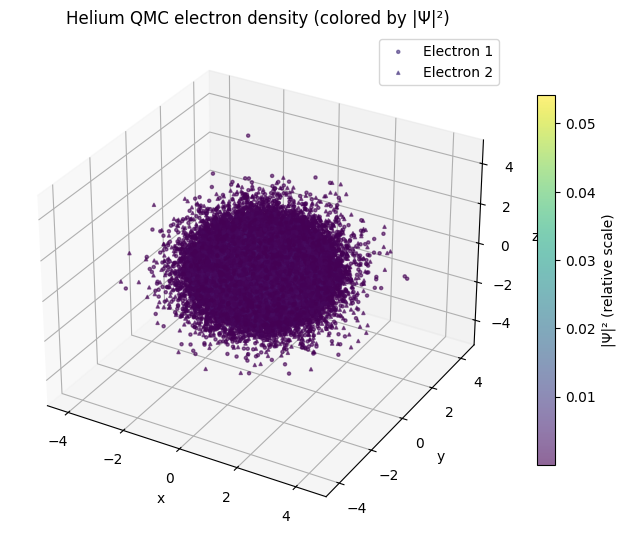

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

# pos.shape = (n_walkers, 6)
# probs.shape = (n_walkers,)

electron1 = pos[:, 0:3]
electron2 = pos[:, 3:6]

# Normalize probabilities to [0, 1] for coloring
norm = colors.Normalize(vmin=prob_density.min(), vmax=prob_density.max())

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Electron 1: circles
sc1 = ax.scatter(electron1[:,0], electron1[:,1], electron1[:,2],
                 c=prob_density, cmap='viridis', norm=norm,
                 s=5, alpha=0.6, marker='o', label="Electron 1")

# Electron 2: triangles
sc2 = ax.scatter(electron2[:,0], electron2[:,1], electron2[:,2],
                 c=prob_density, cmap='viridis', norm=norm,
                 s=5, alpha=0.6, marker='^', label="Electron 2")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("Helium QMC electron density (colored by |Ψ|²)")
ax.legend()

# Single colorbar (shared colormap)
cbar = plt.colorbar(sc1, ax=ax, shrink=0.6)
cbar.set_label("|Ψ|² (relative scale)")

plt.show()


In [ ]:
# Pool both electrons
all_electrons = np.vstack([electron1, electron2])

plt.figure(figsize=(6,5))
plt.hist2d(all_electrons[:,0], all_electrons[:,1],
           bins=200, density=True, cmap="inferno")
plt.colorbar(label="|Ψ|² density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Electron density slice (xy projection)")
plt.show()


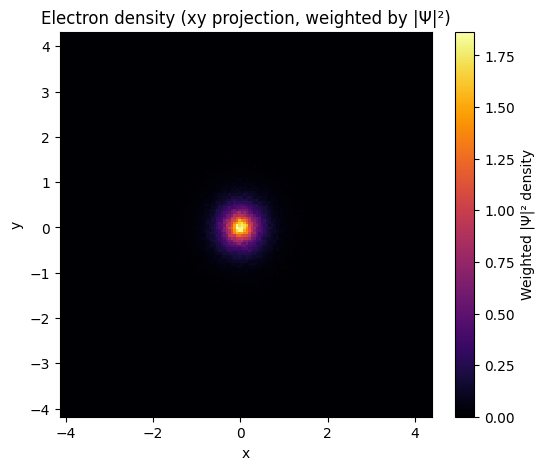

In [126]:
import numpy as np
import matplotlib.pyplot as plt

electron1 = pos[:, 0:3]
electron2 = pos[:, 3:6]

# Stack both electrons
all_electrons = np.vstack([electron1, electron2])
all_probs = np.hstack([prob_density, prob_density])  # duplicate, one weight per electron

# Take xy slice (ignore z)
plt.figure(figsize=(6,5))
plt.hist2d(all_electrons[:,0], all_electrons[:,1],
           bins=150, weights=all_probs,
           density=True, cmap="inferno")
plt.colorbar(label="Weighted |Ψ|² density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Electron density (xy projection, weighted by |Ψ|²)")
plt.show()


In [ ]:
import matplotlib.pyplot as plt


# Configure plot aesthetics using matplotlib rcParams settings
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.major.width'] = 4
plt.rcParams['ytick.major.width'] = 4
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.linewidth'] = 4

fig, ax = plt.subplots(figsize=(16, 16.5))
plt.subplots_adjust(top=0.82)
plt.subplots_adjust(right=0.905)
plt.subplots_adjust(left=-0.1)

# Compute and visualize the wavefunction probability density
psi = compute_wavefunction(n, l, m, a0_scale_factor)
prob_density = compute_probability_density(psi)

# Here we transpose the array to align the calculated z-x plane with Matplotlib's y-x imshow display
im = ax.imshow(np.sqrt(prob_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

cbar = plt.colorbar(im, fraction=0.046, pad=0.03)
cbar.set_ticks([])

# Apply dark theme parameters
if dark_theme:
    theme = 'dt'
    background_color = sorted(
        sns.color_palette(colormap, n_colors=100),
        key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
    )[0]
    plt.rcParams['text.color'] = '#dfdfdf'
    title_color = '#dfdfdf'
    fig.patch.set_facecolor(background_color)
    cbar.outline.set_visible(False)
    ax.tick_params(axis='x', colors='#c4c4c4')
    ax.tick_params(axis='y', colors='#c4c4c4')
    for spine in ax.spines.values():
        spine.set_color('#c4c4c4')

else:  # Apply light theme parameters
    theme = 'lt'
    plt.rcParams['text.color'] = '#000000'
    title_color = '#000000'
    ax.tick_params(axis='x', colors='#000000')
    ax.tick_params(axis='y', colors='#000000')

ax.set_title('Hydrogen Atom - Wavefunction Electron Density', 
                pad=130, fontsize=44, loc='left', color=title_color)
ax.text(0, 722, (
    r'$|\psi_{n \ell m}(r, \theta, \varphi)|^{2} ='
    r' |R_{n\ell}(r) Y_{\ell}^{m}(\theta, \varphi)|^2$'
), fontsize=36)
ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=42)
ax.text(770, 140, 'Electron probability distribution', rotation='vertical', fontsize=40)
ax.text(705, 700, 'Higher\nprobability', fontsize=24)
ax.text(705, -60, 'Lower\nprobability', fontsize=24)
ax.text(775, 590, '+', fontsize=34)
ax.text(769, 82, '−', fontsize=34, rotation='vertical')
ax.invert_yaxis()

# Save and display the plot
plt.savefig(f'({n},{l},{m})[{theme}].png')
plt.show()